# Projeto de TCC
**Autor**: Igor Sousa dos Santos Santana

**Data**: 2024-07-26

## Índice

- [Importando pacotes e Bibliotecas](#importando-pacotes-e-bibliotecas)
- [Importando os Datasets](#importando-os-datasets)
- [Breve Apresentação dos Datasets](#breve-apresentacao-dos-datasets)
- [Breve Limpeza nos Datasets](./limpeza_dados.ipynb)
- [Análise Exploratória de Dados](./analise_exploratoria.ipynb)
- [Preparação dos parâmetros](#preparando-os-hiper-parâmetros)
- [Algoritmo KMeans](#utilizando-o-algoritmo-kmeans)
- [Algoritmo MeanShift](#utilizando-o-algoritmo-meanshift)
- [Algoritmo FuzzyCMeans](#usando-o-algoritmo-fuzzycmeans)
- [Bibliografia](#bibliografia)

## Importando pacotes e Bibliotecas

In [1]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from matplotlib import pyplot as plt
from models import kmeans, meanshift
from fcmeans import FCM
import seaborn as sns
import pandas as pd
import numpy as np

## Importando os Datasets

In [2]:
df_iris_raw = pd.read_csv("./databases/raw/Iris.csv", sep = ",", index_col = "Id")
df_titanic_processed = pd.read_csv("./databases/raw/titanic.csv", sep = ",", index_col = "PassengerId")

## Breve apresentacao dos datasets

In [3]:
df_iris_raw.sample(10)

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
Id,,,,,
35,4.9,3.1,1.5,0.1,Iris-setosa
118,7.7,3.8,6.7,2.2,Iris-virginica
68,5.8,2.7,4.1,1.0,Iris-versicolor
141,6.7,3.1,5.6,2.4,Iris-virginica
107,4.9,2.5,4.5,1.7,Iris-virginica
18,5.1,3.5,1.4,0.3,Iris-setosa
133,6.4,2.8,5.6,2.2,Iris-virginica
90,5.5,2.5,4.0,1.3,Iris-versicolor
33,5.2,4.1,1.5,0.1,Iris-setosa


In [4]:
df_titanic_processed.sample(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
726,0,3,"Oreskovic, Mr. Luka",male,20.0,0,0,315094,8.6625,NaN,S
496,0,3,"Yousseff, Mr. Gerious",male,NaN,0,0,2627,14.4583,NaN,C
819,0,3,"Holm, Mr. John Fredrik Alexander",male,43.0,0,0,C 7075,6.4500,NaN,S
187,1,3,"O'Brien, Mrs. Thomas (Johanna ""Hannah"" Godfrey)",female,NaN,1,0,370365,15.5000,NaN,Q
327,0,3,"Nysveen, Mr. Johan Hansen",male,61.0,0,0,345364,6.2375,NaN,S
724,0,2,"Hodges, Mr. Henry Price",male,50.0,0,0,250643,13.0000,NaN,S
866,1,2,"Bystrom, Mrs. (Karolina)",female,42.0,0,0,236852,13.0000,NaN,S
855,0,2,"Carter, Mrs. Ernest Courtenay (Lilian Hughes)",female,44.0,1,0,244252,26.0000,NaN,S
879,0,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,NaN,S


In [5]:
df_iris_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150 entries, 1 to 150
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SepalLengthCm  150 non-null    float64
 1   SepalWidthCm   150 non-null    float64
 2   PetalLengthCm  150 non-null    float64
 3   PetalWidthCm   150 non-null    float64
 4   Species        150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 7.0+ KB


In [6]:
df_titanic_processed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


## Preparando os hiper parâmetros

In [41]:
X_iris = df_iris_raw.drop(columns = ["Species"]).values
y_iris = df_iris_raw["Species"]

min_max_scaler = MinMaxScaler()
X_titanic = min_max_scaler.fit_transform(df_titanic_processed.drop(columns = ["Pclass", "Name"]).values)
y_titanic = df_titanic_processed["Pclass"]

In [42]:
nro_max_iteracoes = 300
nro_iteracoes_inicial = 10
semente_randomica = 42
parametro_fuzzy = 2

## Utilizando o algoritmo Kmeans

In [43]:
soma_dos_quadrados_iris = []
soma_dos_quadrados_titanic = []

for i in range (1, 14):
    kmeans = KMeans(n_clusters = i,
                    init = "k-means++",
                    max_iter = nro_max_iteracoes,
                    n_init = nro_iteracoes_inicial,
                    random_state = semente_randomica)
    kmeans.fit(X_iris)
    soma_dos_quadrados_iris.append(kmeans.inertia_)
    
    kmeans = KMeans(n_clusters = i,
                    init = "k-means++",
                    max_iter = nro_max_iteracoes,
                    n_init = nro_iteracoes_inicial,
                    random_state = semente_randomica)
    kmeans.fit(X_titanic)
    soma_dos_quadrados_titanic.append(kmeans.inertia_)

### Imprimindo o resultado dos testes

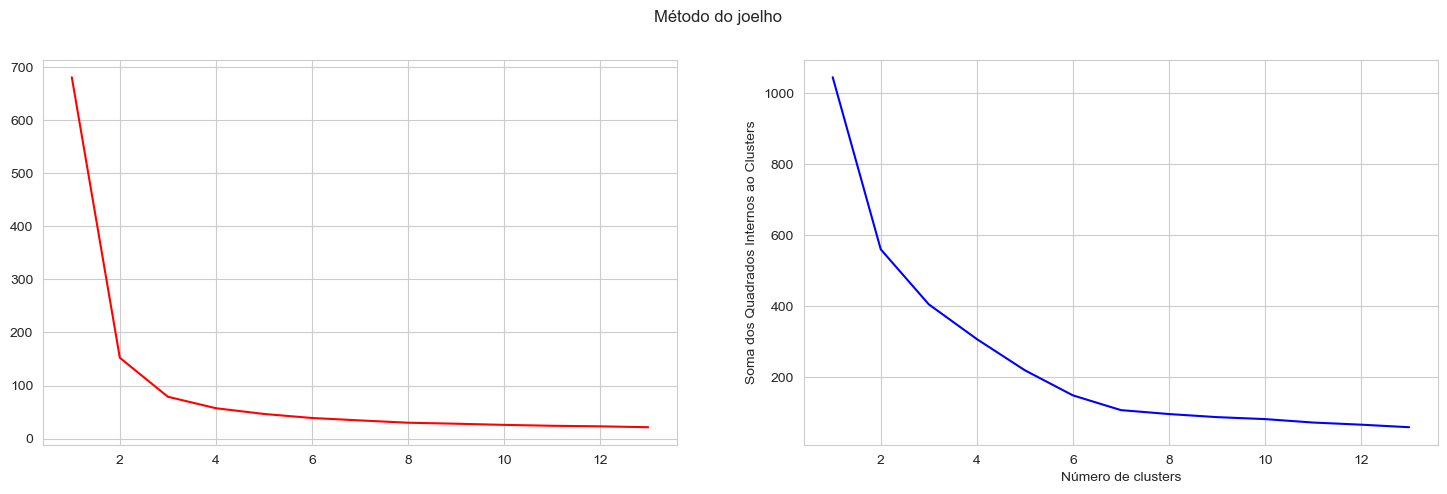

In [44]:
figura, eixos = plt.subplots(1, 2, figsize = (18, 5))

plt.suptitle("Método do joelho")
plt.xlabel("Número de clusters")
plt.ylabel("Soma dos Quadrados Internos ao Clusters")

eixos[0].plot(range(1, 14), soma_dos_quadrados_iris, color = "red")
eixos[1].plot(range(1, 14), soma_dos_quadrados_titanic, color = "blue")

plt.show()

No caso acima, o resultado a partir do número 3 decai muito, portanto o número de clusters escolhido é:
- `3` para o dataset `Iris`;
- `3` para o dataset `Titanic`.

### Implementando a clusterização

#### Dataset Iris

In [45]:
kmeans_iris = KMeans(n_clusters = 3,
                    init = "k-means++",
                    max_iter = nro_max_iteracoes,
                    n_init = nro_iteracoes_inicial,
                    random_state = semente_randomica)
y_kmeans_iris = kmeans_iris.fit_predict(X_iris)

#### Dataset Titanic

In [46]:
kmeans_titanic = KMeans(n_clusters = 3,
                        init = "k-means++",
                        max_iter = nro_max_iteracoes,
                        n_init = nro_iteracoes_inicial,
                        random_state = semente_randomica)
y_kmeans_titanic = kmeans_titanic.fit_predict(X_titanic)

##### Visualizando os clusters

###### De forma 2D

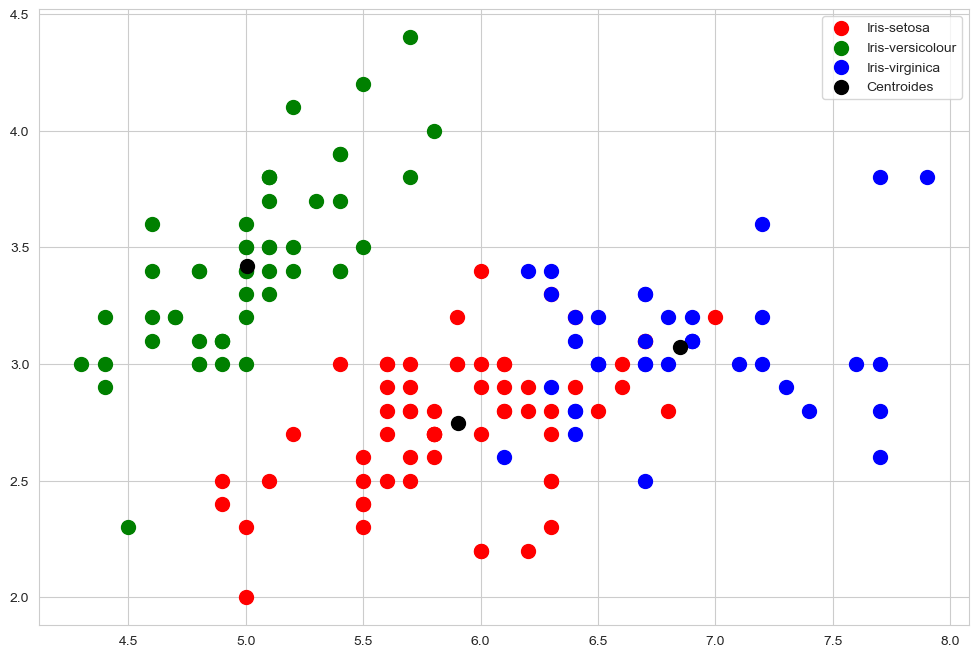

In [47]:
plt.figure(figsize = (12, 8))

### OS PONTOS GERAIS
plt.scatter(X_iris[y_kmeans_iris == 0, 0], X_iris[y_kmeans_iris == 0, 1], s = 100, c = "red", label = "Iris-setosa")
plt.scatter(X_iris[y_kmeans_iris == 1, 0], X_iris[y_kmeans_iris == 1, 1], s = 100, c = "green", label = "Iris-versicolour")
plt.scatter(X_iris[y_kmeans_iris == 2, 0], X_iris[y_kmeans_iris == 2, 1], s = 100, c = "blue", label = "Iris-virginica")

### OS CENTROIDES
plt.scatter(kmeans_iris.cluster_centers_[:, 0], kmeans_iris.cluster_centers_[:, 1], s = 100, c = "black", label = "Centroides")

plt.legend()
plt.show()

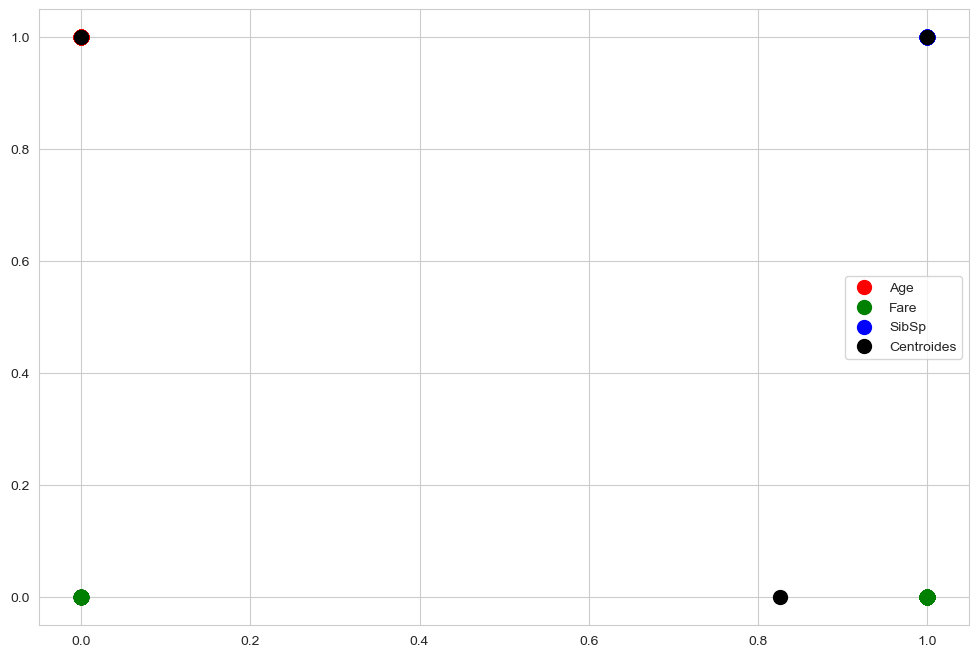

In [48]:
plt.figure(figsize = (12, 8))

### OS PONTOS GERAIS
plt.scatter(X_titanic[y_kmeans_titanic == 0, 0], X_titanic[y_kmeans_titanic == 0, 1], s = 100, c = "red", label = "Age")
plt.scatter(X_titanic[y_kmeans_titanic == 1, 0], X_titanic[y_kmeans_titanic == 1, 1], s = 100, c = "green", label = "Fare")
plt.scatter(X_titanic[y_kmeans_titanic == 2, 0], X_titanic[y_kmeans_titanic == 2, 1], s = 100, c = "blue", label = "SibSp")

### OS CENTROIDES
plt.scatter(kmeans_titanic.cluster_centers_[:, 0], kmeans_titanic.cluster_centers_[:, 1], s = 100, c = "black", label = "Centroides")

plt.legend()
plt.show()

###### De forma 3D

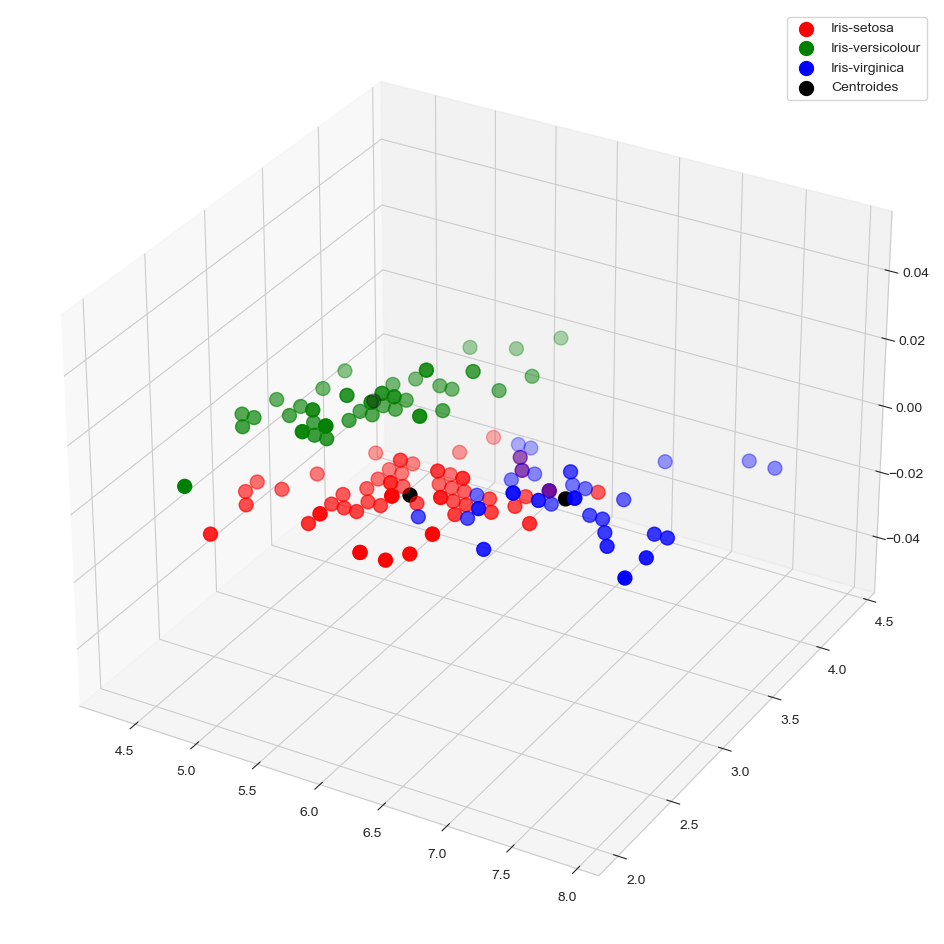

In [49]:
figura = plt.figure(figsize = (12, 12))
eixo = figura.add_subplot(111, projection = "3d")

### OS PONTOS GERAIS
plt.scatter(X_iris[y_kmeans_iris == 0, 0], X_iris[y_kmeans_iris == 0, 1], s = 100, c = "red", label = "Iris-setosa")
plt.scatter(X_iris[y_kmeans_iris == 1, 0], X_iris[y_kmeans_iris == 1, 1], s = 100, c = "green", label = "Iris-versicolour")
plt.scatter(X_iris[y_kmeans_iris == 2, 0], X_iris[y_kmeans_iris == 2, 1], s = 100, c = "blue", label = "Iris-virginica")

### OS CENTROIDES
plt.scatter(kmeans_iris.cluster_centers_[:, 0], kmeans_iris.cluster_centers_[:,1], s = 100, c = "black", label = "Centroides")

plt.legend()
plt.show()

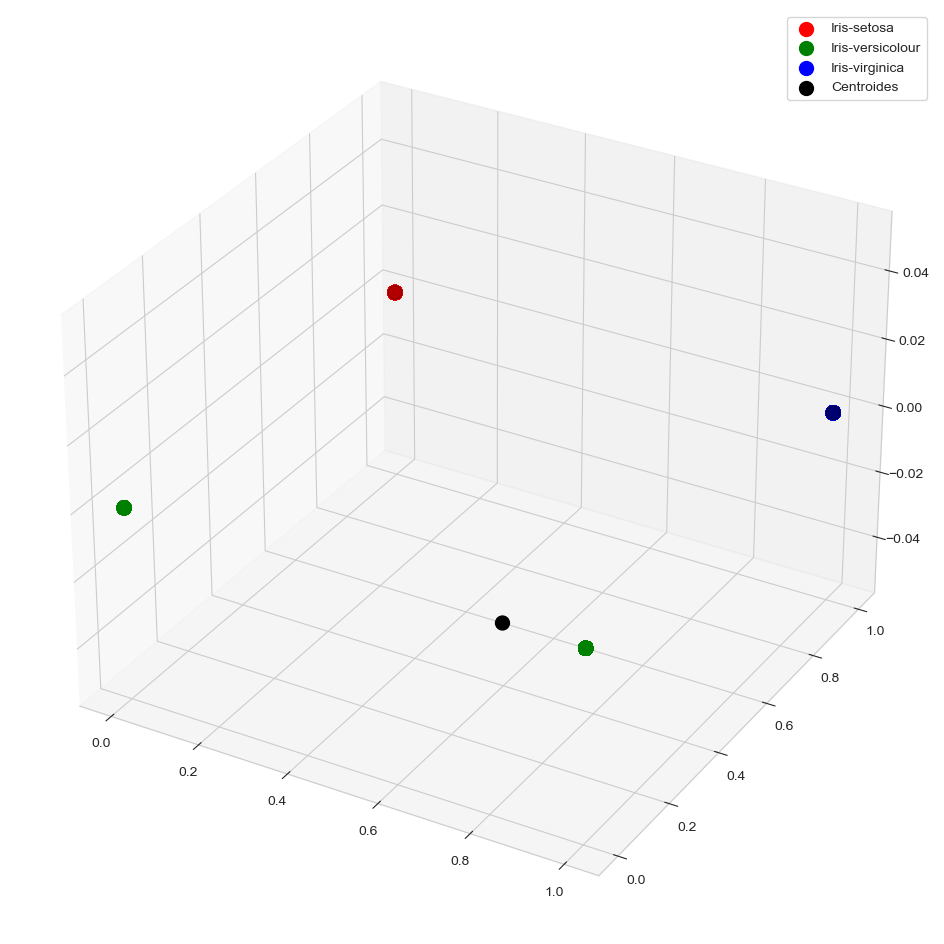

In [50]:
figura = plt.figure(figsize = (12, 12))
eixo = figura.add_subplot(111, projection = "3d")

### OS PONTOS GERAIS
plt.scatter(X_titanic[y_kmeans_titanic == 0, 0], X_titanic[y_kmeans_titanic == 0, 1], s = 100, c = "red", label = "Iris-setosa")
plt.scatter(X_titanic[y_kmeans_titanic == 1, 0], X_titanic[y_kmeans_titanic == 1, 1], s = 100, c = "green", label = "Iris-versicolour")
plt.scatter(X_titanic[y_kmeans_titanic == 2, 0], X_titanic[y_kmeans_titanic == 2, 1], s = 100, c = "blue", label = "Iris-virginica")

### OS CENTROIDES
plt.scatter(kmeans_titanic.cluster_centers_[:, 0], kmeans_titanic.cluster_centers_[:,1], s = 100, c = "black", label = "Centroides")

plt.legend()
plt.show()

## Utilizando o algoritmo Meanshift

In [51]:
# IRIS
meanShift_iris = MeanShift()
meanShift_iris.fit(X_iris)

labels_iris = meanShift_iris.labels_
centros_iris = meanShift_iris.cluster_centers_
###############################################

###############################################
# TITANIC
meanShift_titanic = MeanShift()
meanShift_titanic.fit(X_titanic)

labels_titanic = meanShift_titanic.labels_
centros_titanic = meanShift_titanic.cluster_centers_

### Visualizando os Resultados

In [52]:
nro_de_clusters = len(np.unique(labels_iris))
print(f"Número estimado de clusters [iris] = {nro_de_clusters}", end = "\n")
print(f"Quantidade de labels = {len(centros_iris)}", end = "\n")

nro_de_clusters = len(np.unique(labels_titanic))
print(f"Número estimado de clusters [titanic] = {nro_de_clusters}", end = "\n")
print(f"Quantidade de labels = {len(centros_titanic)}", end = "\n")

Número estimado de clusters [iris] = 2
Quantidade de labels = 2
Número estimado de clusters [titanic] = 8
Quantidade de labels = 8


### Visualizando os resultados de forma gráfica

#### Dataset Iris

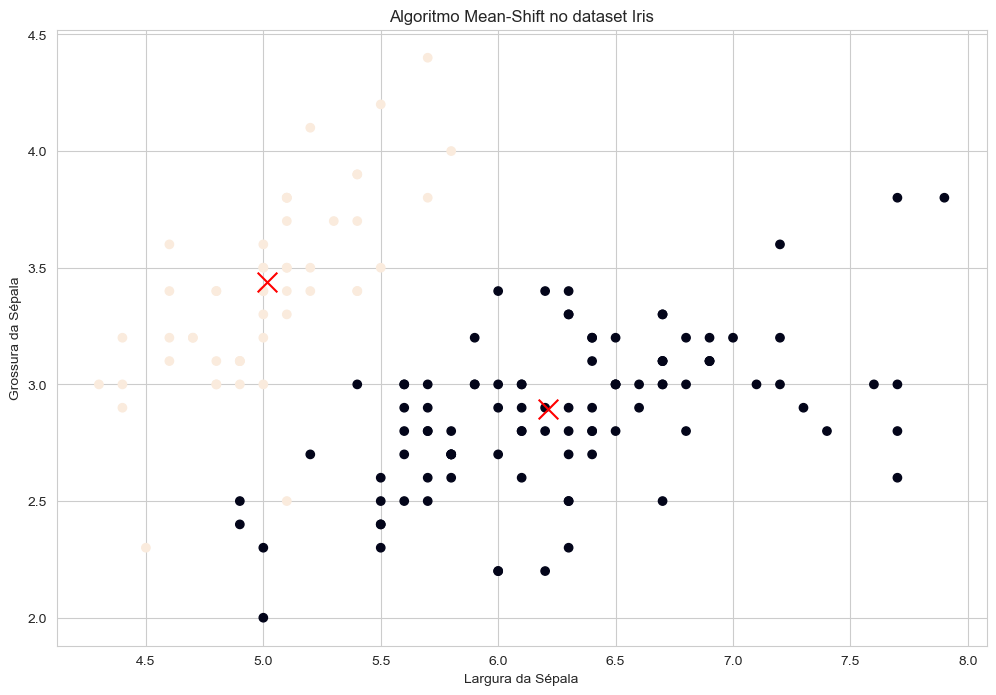

In [53]:
plt.figure(figsize = (12, 8))
plt.scatter(X_iris[:, 0], X_iris[:, 1], c = labels_iris)
plt.scatter(centros_iris[:, 0], centros_iris[:, 1], marker = "x", color = "red", s = 200)
plt.xlabel("Largura da Sépala")
plt.ylabel("Grossura da Sépala")
plt.title("Algoritmo Mean-Shift no dataset Iris")
plt.show()

#### Dataset Titanic

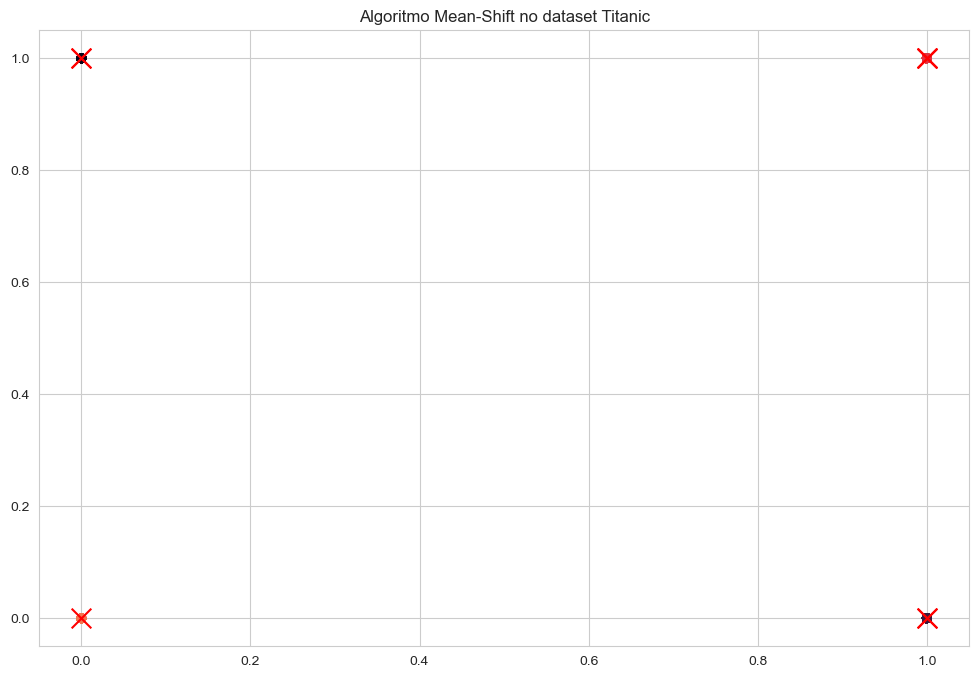

In [54]:
plt.figure(figsize = (12, 8))
plt.scatter(X_titanic[:, 0], X_titanic[:, 1], c = labels_titanic)
plt.scatter(centros_titanic[:, 0], centros_titanic[:, 1], marker = "x", color = "red", s = 200)
plt.title("Algoritmo Mean-Shift no dataset Titanic")
plt.show()

## Usando o algoritmo FuzzyCMeans

### Imprimindo o resultado dos testes - Dataset Iris

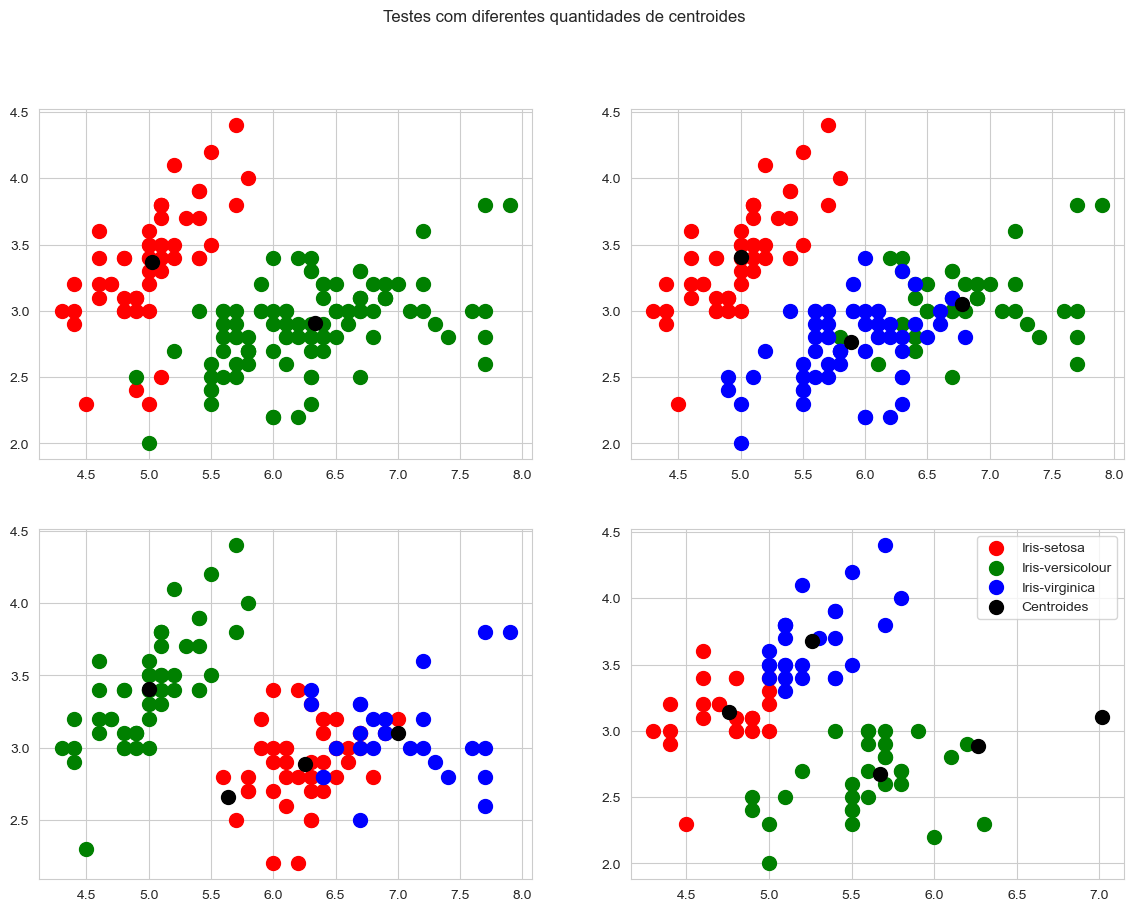

In [55]:
figura, eixos = plt.subplots(nrows = 2, ncols = 2, figsize = (14, 10))
j, k = 0, 0

for i in range (2, 6):
    cmeans = FCM(n_clusters = i,
                 m = parametro_fuzzy,
                 max_iter = nro_max_iteracoes,
                 n_init = nro_iteracoes_inicial,
                 random_state = semente_randomica)

    cmeans.fit(X_iris)
    y_cmeans = cmeans.predict(X_iris)
    centros = cmeans.centers
    
    
    ### OS PONTOS GERAIS
    eixos[j][k].scatter(X_iris[y_cmeans == 0, 0], X_iris[y_cmeans == 0, 1], s = 100, c = "red", label = "Iris-setosa")
    eixos[j][k].scatter(X_iris[y_cmeans == 1, 0], X_iris[y_cmeans == 1, 1], s = 100, c = "green", label = "Iris-versicolour")
    eixos[j][k].scatter(X_iris[y_cmeans == 2, 0], X_iris[y_cmeans == 2, 1], s = 100, c = "blue", label = "Iris-virginica")

    ### OS CENTROIDES
    eixos[j][k].scatter(centros[:, 0], centros[:, 1], s = 100, c = "black", label = "Centroides")
    
    k = (k - 1) * (-1)
    j = 1 if i > 2 else 0

plt.suptitle("Testes com diferentes quantidades de centroides")
plt.legend()
plt.show()

No caso acima, valor 3 é o que melhor descreve o conjunto dos pontos. Então será escolhido 3 como parâmetro para futuros testes no modelo

### Implementando a clusterização - Dataset Iris

In [56]:
parametro_fuzzy = 2
nro_de_clusters = 3

cmeans_iris = FCM(n_clusters = nro_de_clusters,
                m = parametro_fuzzy,
                max_iter = nro_max_iteracoes,
                n_init = nro_iteracoes_inicial,
                random_state = semente_randomica)

cmeans_iris.fit(X_iris)
y_cmeans_iris = cmeans_iris.predict(X_iris)
centros_iris = cmeans_iris.centers

##### Visualizando os clusters

###### De forma 2D

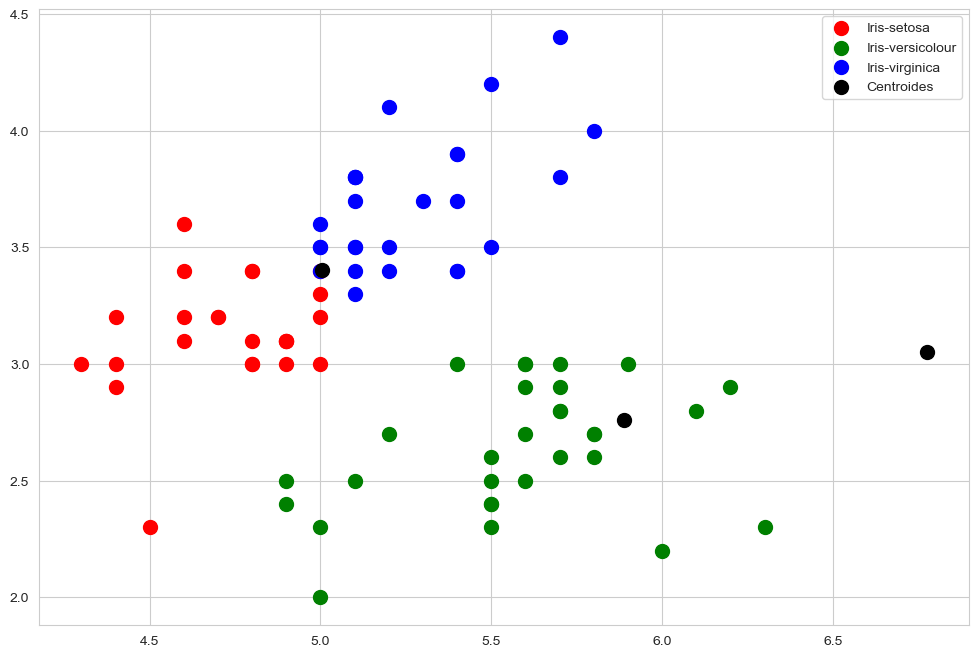

In [57]:
plt.figure(figsize = (12, 8))

### OS PONTOS GERAIS
plt.scatter(X_iris[y_cmeans == 0, 0], X_iris[y_cmeans == 0, 1], s = 100, c = "red", label = "Iris-setosa")
plt.scatter(X_iris[y_cmeans == 1, 0], X_iris[y_cmeans == 1, 1], s = 100, c = "green", label = "Iris-versicolour")
plt.scatter(X_iris[y_cmeans == 2, 0], X_iris[y_cmeans == 2, 1], s = 100, c = "blue", label = "Iris-virginica")

### OS CENTROIDES

plt.scatter(centros_iris[:, 0], centros_iris[:, 1], s = 100, c = "black", label = "Centroides")

plt.legend()
plt.show()

###### De forma 3D

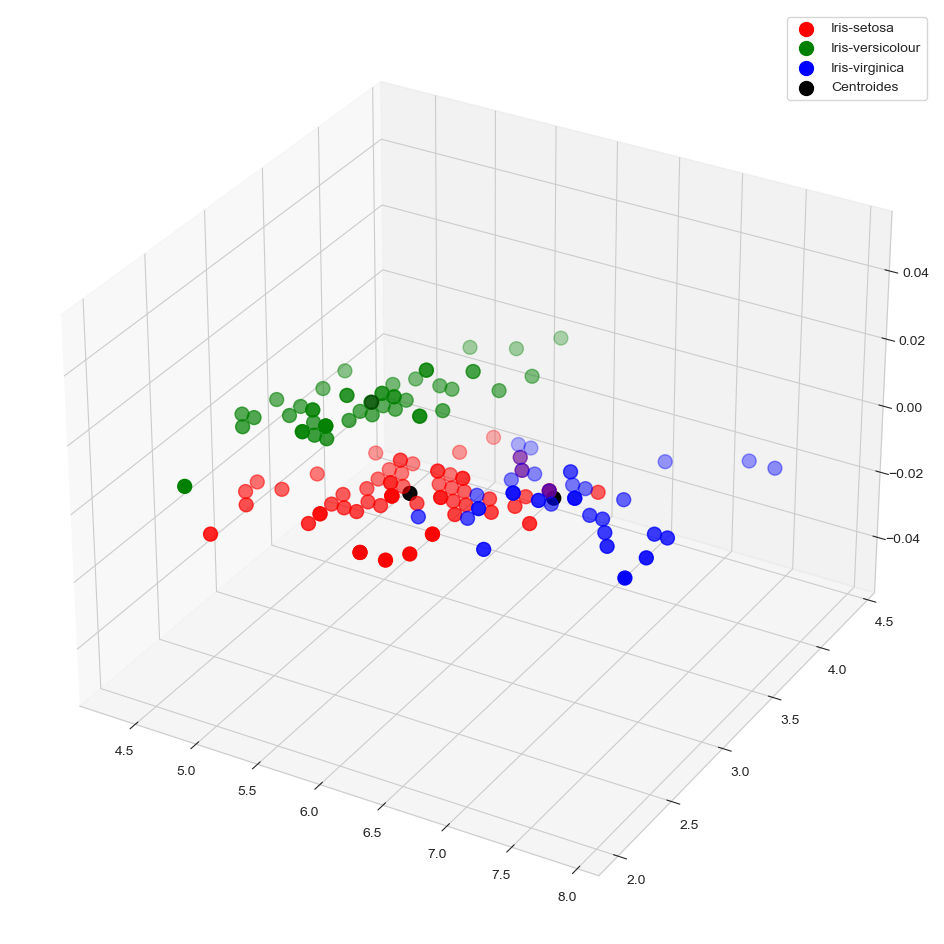

In [58]:
figura = plt.figure(figsize = (12, 12))
eixo = figura.add_subplot(111, projection = "3d")

### OS PONTOS GERAIS
plt.scatter(X_iris[y_kmeans_iris == 0, 0], X_iris[y_kmeans_iris == 0, 1], s = 100, c = "red", label = "Iris-setosa")
plt.scatter(X_iris[y_kmeans_iris == 1, 0], X_iris[y_kmeans_iris == 1, 1], s = 100, c = "green", label = "Iris-versicolour")
plt.scatter(X_iris[y_kmeans_iris == 2, 0], X_iris[y_kmeans_iris == 2, 1], s = 100, c = "blue", label = "Iris-virginica")

### OS CENTROIDES
plt.scatter(centros_iris[:, 0], centros_iris[:, 1], s = 100, c = "black", label = "Centroides")

plt.legend()
plt.show()

### Imprimindo o resultado dos testes - Dataset Titanic

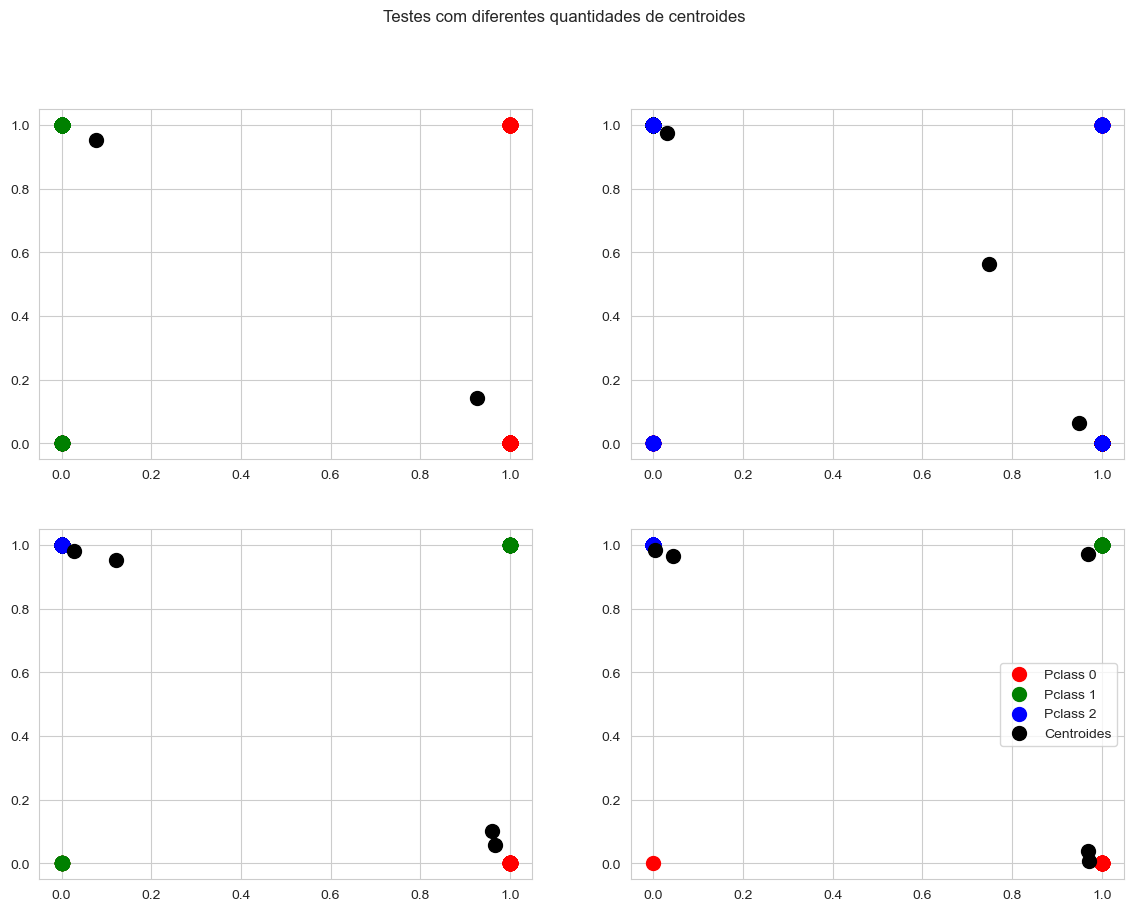

In [59]:
parametro_fuzzy = 2
figura, eixos = plt.subplots(nrows = 2, ncols = 2, figsize = (14, 10))
j, k = 0, 0

for i in range (2, 6):
    cmeans = FCM(n_clusters = i,
                 m = parametro_fuzzy,
                 max_iter = nro_max_iteracoes,
                 n_init = nro_iteracoes_inicial,
                 random_state = semente_randomica)

    cmeans.fit(X_titanic)
    y_cmeans = cmeans.predict(X_titanic)
    centros = cmeans.centers
    
    
    ### OS PONTOS GERAIS
    eixos[j][k].scatter(X_titanic[y_cmeans == 0, 0], X_titanic[y_cmeans == 0, 1], s = 100, c = "red", label = "Pclass 0")
    eixos[j][k].scatter(X_titanic[y_cmeans == 1, 0], X_titanic[y_cmeans == 1, 1], s = 100, c = "green", label = "Pclass 1")
    eixos[j][k].scatter(X_titanic[y_cmeans == 2, 0], X_titanic[y_cmeans == 2, 1], s = 100, c = "blue", label = "Pclass 2")

    ### OS CENTROIDES
    eixos[j][k].scatter(centros[:, 0], centros[:, 1], s = 100, c = "black", label = "Centroides")
    
    k = (k - 1) * (-1)
    j = 1 if i > 2 else 0

plt.suptitle("Testes com diferentes quantidades de centroides")
plt.legend()
plt.show()

No caso acima, nenhum valor descreve melhor o conjunto dos pontos.
Mas será escolhido 3 como parâmetro para futuros testes no modelo, pois já sabemos que há 3 clusters

### Implementando a clusterização - Dataset Titanic

In [60]:
parametro_fuzzy = 2
nro_de_clusters = 3

cmeans_titanic = FCM(n_clusters = nro_de_clusters,
                    m = parametro_fuzzy,
                    max_iter = nro_max_iteracoes,
                    n_init = nro_iteracoes_inicial,
                    random_state = semente_randomica)

cmeans_titanic.fit(X_titanic)
y_cmeans_titanic = cmeans_titanic.predict(X_titanic)
centros_titanic = cmeans_titanic.centers

##### Visualizando os clusters

###### De forma 2D

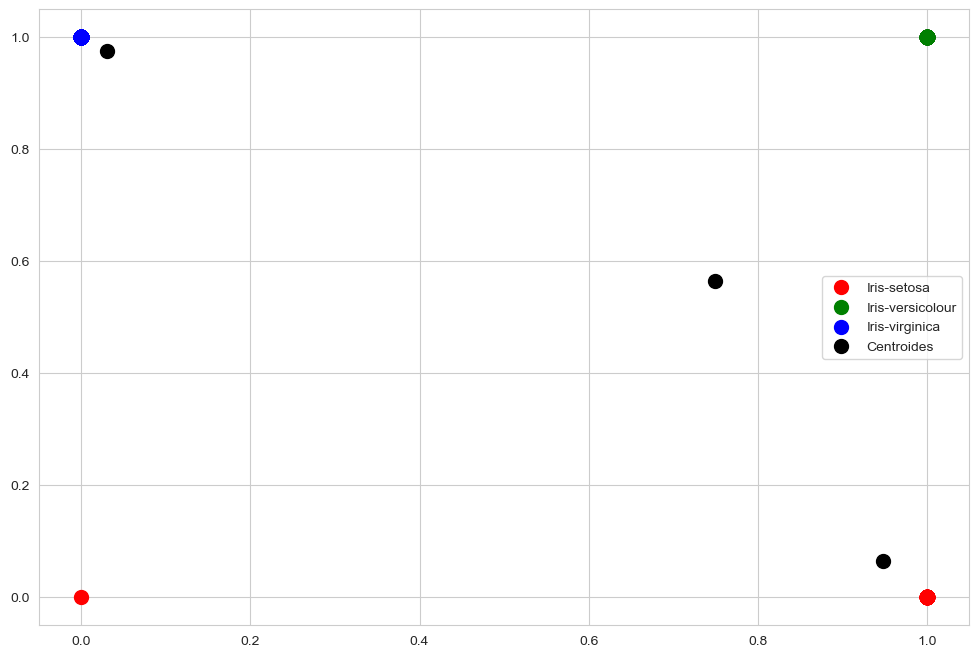

In [61]:
plt.figure(figsize = (12, 8))

### OS PONTOS GERAIS
plt.scatter(X_titanic[y_cmeans == 0, 0], X_titanic[y_cmeans == 0, 1], s = 100, c = "red", label = "Iris-setosa")
plt.scatter(X_titanic[y_cmeans == 1, 0], X_titanic[y_cmeans == 1, 1], s = 100, c = "green", label = "Iris-versicolour")
plt.scatter(X_titanic[y_cmeans == 2, 0], X_titanic[y_cmeans == 2, 1], s = 100, c = "blue", label = "Iris-virginica")

### OS CENTROIDES

plt.scatter(centros_titanic[:, 0], centros_titanic[:, 1], s = 100, c = "black", label = "Centroides")

plt.legend()
plt.show()

###### De forma 3D

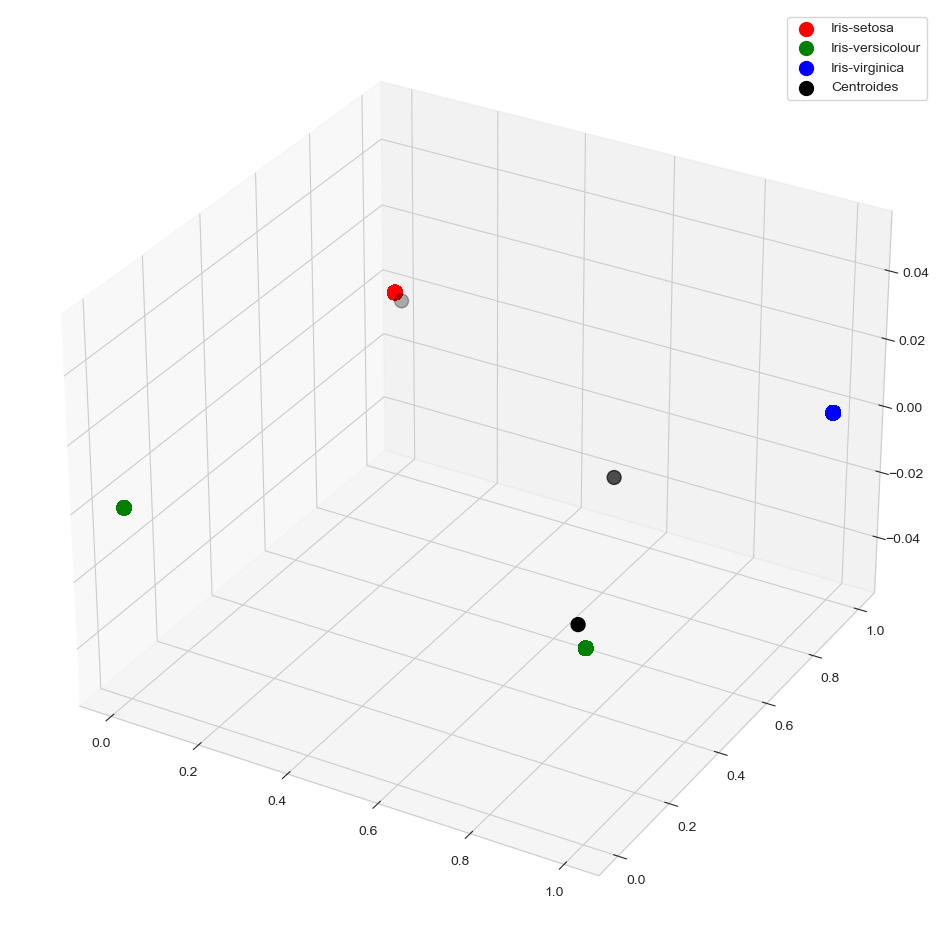

In [62]:
figura = plt.figure(figsize = (12, 12))
eixo = figura.add_subplot(111, projection = "3d")

### OS PONTOS GERAIS
plt.scatter(X_titanic[y_kmeans_titanic == 0, 0], X_titanic[y_kmeans_titanic == 0, 1], s = 100, c = "red", label = "Iris-setosa")
plt.scatter(X_titanic[y_kmeans_titanic == 1, 0], X_titanic[y_kmeans_titanic == 1, 1], s = 100, c = "green", label = "Iris-versicolour")
plt.scatter(X_titanic[y_kmeans_titanic == 2, 0], X_titanic[y_kmeans_titanic == 2, 1], s = 100, c = "blue", label = "Iris-virginica")

### OS CENTROIDES
plt.scatter(centros_titanic[:, 0], centros_titanic[:, 1], s = 100, c = "black", label = "Centroides")

plt.legend()
plt.show()

## Bibliografia

### SCIKIT-LEARN
- https://scikit-learn.org/stable/

### SCIKIT-LEARN.KMEANS
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

### SCIKIT-LEARN.MEANSHIFT
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html
- https://scikit-learn.org/stable/auto_examples/cluster/plot_mean_shift.html

### FUZZY_C_MEANS
- https://pypi.org/project/fuzzy-c-means/
	- https://github.com/omadson/fuzzy-c-means
- https://github.com/ShristiK/Fuzzy-C-Means-Clustering
- https://pythonhosted.org/scikit-fuzzy/auto_examples/plot_cmeans.html
- https://www.kaggle.com/code/prateekk94/fuzzy-c-means-clustering-on-iris-dataset
- https://fda.readthedocs.io/en/latest/index.html
	- https://fda.readthedocs.io/en/latest/modules/ml/autosummary/skfda.ml.clustering.FuzzyCMeans.html
